In [29]:
import cv2

import os
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from numpy import newaxis
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from keras.layers import core, Conv2D, pooling, Lambda, Flatten, Dropout, Dense

---
## Step 1: Data Loading and PreProcessing

### Steps:
-  Loading the training images and steering angle data.
-  Cropping the image to extract the road information.
-  Resizing the image to lower resolution for faster processing.

In [3]:
DATA_DIR = './data/'
labels_file = './data/driving_log.csv'

In [4]:
def load_data(labels_file, test_size):
    labels = pd.read_csv(labels_file)
    X = labels[['center', 'left', 'right']].values
    y = labels['steering'].values
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=0)
    return X_train, X_valid, y_train, y_valid

In [5]:
def load_image(image_file):
    return mpimg.imread(os.path.join(DATA_DIR, image_file.strip()))

In [6]:
X_train, X_valid, y_train, y_valid = load_data(labels_file, 0.2)
print(X_train.shape)
print(y_train.shape)

(6428, 3)
(6428,)


In [183]:
def display(image, angle, label = ""):
    plt.figure(figsize=(10,7))
    plt.imshow(image)
    plt.xlabel("Steering angle: {:.5f}".format(angle))
    plt.title(label)
    plt.show()

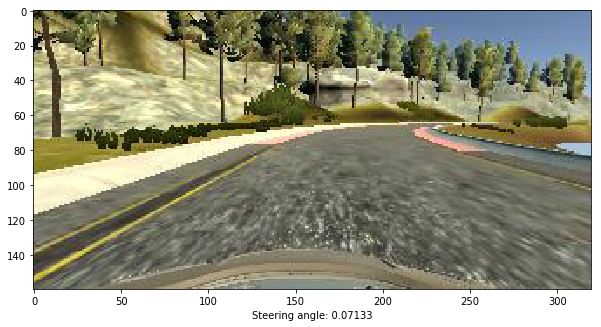

In [184]:
image = load_image(X_train[1,0])
steeringAngle = y_train[1]
display(image, steeringAngle)

In [185]:
img_height, img_width, img_channels = 66, 200, 3
input_shape = (img_height, img_width, img_channels)

In [186]:
def image_preprocessing(img):
    # Cropping the image
    img = img[60:135, :, :] #cropping the top 60 and bottom 25 px
    # Resizing the image
    img = cv2.resize(img, (img_width, img_height), cv2.INTER_AREA)
    return img

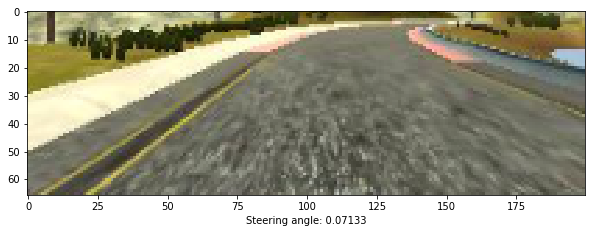

In [187]:
image = image_preprocessing(load_image(X_train[1,0]))
steeringAngle = y_train[1]
display(image, steeringAngle)

---
## Step 2: Data Augmentation

### Steps:
-  Steering angle adjustment according to the chosen left/center/right camera.
-  Flipping images 180 degrees and reversing the steering angle.
-  Changing the brightness of images.

In [188]:
def random_adjust(chosenCamera, sampleNo):
    centerImg, leftImg, rightImg = X_train[sampleNo] # Image path
    steeringAngle = y_train[sampleNo] # steering angle
    
    #Adjusting the steering angle depending on the image selected.
    #we're basically adding/subtracting a fixed value but this can also be kept as a hyperparameter for tuning. 
    if chosenCamera == 0:
        return load_image(centerImg), steeringAngle
    elif chosenCamera == 1:
        return load_image(leftImg), steeringAngle + 0.2
    else:
        return load_image(rightImg), steeringAngle - 0.2

In [189]:
def random_flip(image, steeringAngle):
    #As pointed out in the class, the simulation track consists of more left turns than right.
    #In order to train the network to be robust to both left and right turns, images are being randomly flipped
    #and steering angle reversed.
    if np.random.rand() < 0.5:
        return cv2.flip(image, 1), -steeringAngle
    else:
        return image, steeringAngle

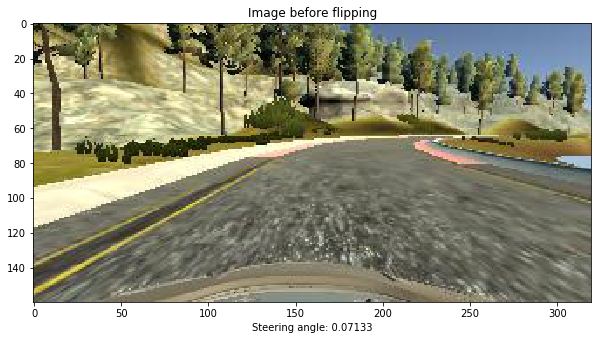

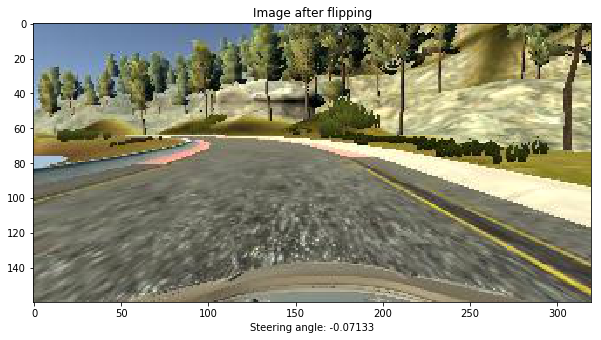

In [190]:
image = load_image(X_train[1,0])
steeringAngle = y_train[1]
label = "Image before flipping"
display(image, steeringAngle, label)

image = random_flip(image, steeringAngle)
label = "Image after flipping"
display(image[0], image[1], label)

In [59]:
def random_brightness(image):
    """
    Random gamma correction is used as an alternative method for changing the brightness of
    training images.
    http://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
    :param image:
        Source image
    :return:
        New image generated by applying gamma correction to the source image
    """
    gamma = np.random.uniform(0.5, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

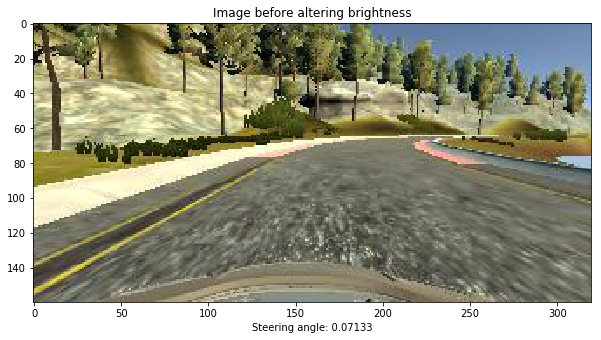

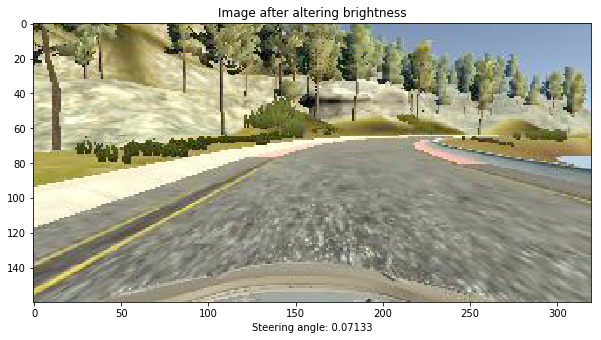

In [195]:
image = load_image(X_train[1,0])
steeringAngle = y_train[1]
label = "Image before altering brightness"
display(image, steeringAngle, label)

image = random_brightness(image)
label = "Image after altering brightness"
display(image, steeringAngle, label)

In [61]:
def data_augumentation(chosenCamera, sampleNo):
    #this serves as the preprocessing pipeline function.
    #the image to be selected is passed from the batcher along with the image index.
    image, steeringAngle = random_adjust(chosenCamera, sampleNo)
    image, steeringAngle = random_flip(image, steeringAngle)
    image = random_brightness(image)
    return image, steeringAngle

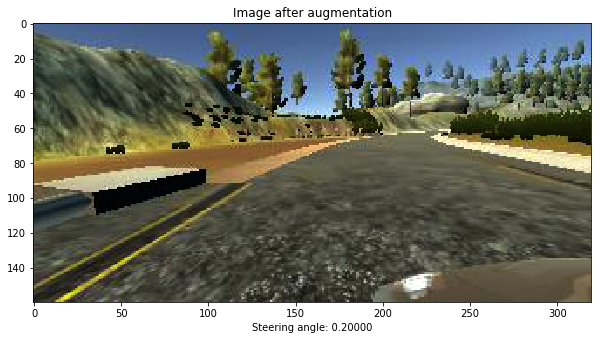

In [192]:
chosenCamera = 2
sampleNo = 10
image, steeringAngle = data_augumentation(chosenCamera, sampleNo)
label = "Image after augmentation"
display(image, steeringAngle, label)

---
## Step 3: Model Architecture

Using the ConvNet from NVIDIA's paper [End to End Learning for Self-Driving Cars](https://arxiv.org/pdf/1604.07316v1.pdf), which has been proven to work in this problem domain.

In [199]:
def batcher(batch_size):
    inputs = np.empty([batch_size, img_height, img_width, img_channels], dtype=float)
    targets = np.empty(batch_size, dtype=float)
    samples = X_train.shape[0]
    while True:
        batchCounter = 0
        for sample in np.random.permutation(samples):
            carCamera = np.random.choice(3)
            image, steeringAngle = data_augumentation(carCamera,sample)
            inputs[batchCounter] = image_preprocessing(image)
            targets[batchCounter] = steeringAngle
            batchCounter += 1
            if batchCounter == batch_size:
                break
        yield inputs, targets

In [200]:
def batcher_validation(batch_size):
    inputs = np.empty([batch_size, img_height, img_width, img_channels], dtype=float)
    targets = np.empty(batch_size, dtype=float)
    samples = X_valid.shape[0]
    while True:
        batchCounter = 0
        for sample in np.random.permutation(samples):
            image = load_image(X_valid[sample,0]) #grab the center image for validation
            steeringAngle = y_valid[sample]
            inputs[batchCounter] = image_preprocessing(image)
            targets[batchCounter] = steeringAngle
            batchCounter += 1
            if batchCounter == batch_size:
                break
        yield inputs, targets

In [204]:
#defining the model architecture.
batch_size = 50
samples_per_epoch = 20000
nb_epoch = 10

model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=input_shape))
model.add(Conv2D(16, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Conv2D(32, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='relu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='relu', subsample=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.summary()

model.compile(optimizer=Adam(lr=1.0e-4), loss='mse', metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_21 (Lambda)               (None, 66, 200, 3)    0           lambda_input_21[0][0]            
____________________________________________________________________________________________________
convolution2d_77 (Convolution2D) (None, 31, 98, 16)    1216        lambda_21[0][0]                  
____________________________________________________________________________________________________
convolution2d_78 (Convolution2D) (None, 14, 47, 32)    12832       convolution2d_77[0][0]           
____________________________________________________________________________________________________
convolution2d_79 (Convolution2D) (None, 6, 23, 64)     18496       convolution2d_78[0][0]           
___________________________________________________________________________________________

---
## Step 4: Model Training and Evaluation

In [205]:
#training on the model using the training data
history_callback_training = model.fit_generator(batcher(batch_size), samples_per_epoch, nb_epoch 
                                                ,validation_data=batcher_validation(batch_size)
                                                ,nb_val_samples=len(X_valid))
model.save('model.h5')

Epoch 1/10
20000/20000 [==============================] - 253s - loss: 0.0298 - acc: 0.1789 - val_loss: 0.0147 - val_acc: 0.5685

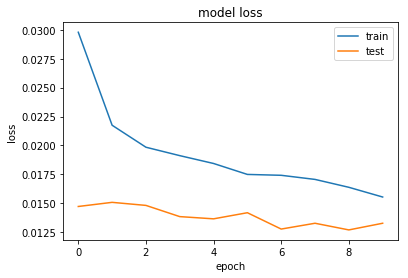

In [207]:
#plotting the loss
#training_loss = history_callback_training.history["loss"]
plt.plot(history_callback_training.history['loss'])
plt.plot(history_callback_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()